<a href="https://colab.research.google.com/github/moupriya20/mou_m/blob/main/Image_Super_Resolution_using_SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Install & Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from skimage import color, io, transform


Step 2: Load Any Image

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

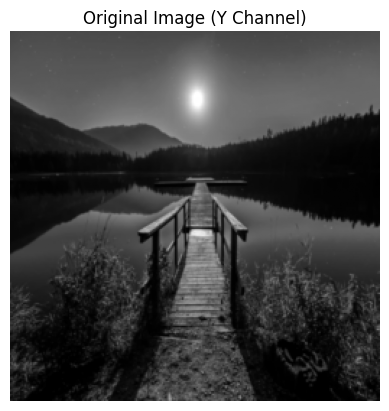

In [3]:
url = "pexels-photo-414612.jpeg"
image = io.imread(url)
image = transform.resize(image, (256, 256))  # resize to fixed size
image = color.rgb2ycbcr(image)

# Use only Y channel for SRCNN
y = image[:, :, 0]
plt.imshow(y, cmap='gray')
plt.title("Original Image (Y Channel)")
plt.axis('off')


Step 3: Create Low-Resolution Image

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

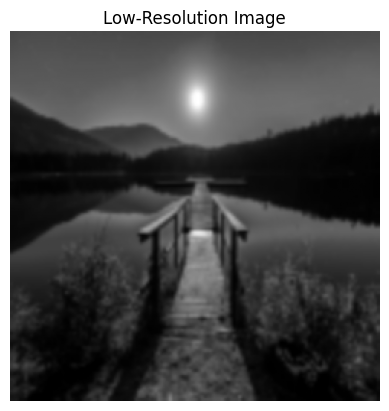

In [4]:
# Downscale and upscale to simulate low-resolution
low_res = transform.resize(y, (128, 128))
low_res = transform.resize(low_res, (256, 256))

plt.imshow(low_res, cmap='gray')
plt.title("Low-Resolution Image")
plt.axis('off')


Step 4: Build SRCNN Model

In [5]:
SRCNN = Sequential()

SRCNN.add(Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(None, None, 1)))
SRCNN.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
SRCNN.add(Conv2D(1, (5, 5), activation='linear', padding='same'))

SRCNN.compile(optimizer='adam', loss='mse')
SRCNN.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, None, None, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 1)  │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

Step 5: Prepare Training Data From One Image

In [6]:
def extract_patches(image, patch_size=33, stride=14):
    patches_lr = []
    patches_hr = []

    for i in range(0, image.shape[0]-patch_size, stride):
        for j in range(0, image.shape[1]-patch_size, stride):
            hr = image[i:i+patch_size, j:j+patch_size]
            lr = transform.resize(hr, (patch_size//2, patch_size//2))
            lr = transform.resize(lr, (patch_size, patch_size))

            patches_hr.append(hr)
            patches_lr.append(lr)

    return np.array(patches_lr), np.array(patches_hr)

X, Y = extract_patches(y)

# reshape for CNN
X = X.reshape(-1, 33, 33, 1)
Y = Y.reshape(-1, 33, 33, 1)

print("Training patches:", X.shape)


Training patches: (256, 33, 33, 1)


Step 6: Train SRCNN



In [7]:
SRCNN.fit(X, Y, epochs=10, batch_size=16)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 2350.0845
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 465.3072
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 278.2817
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 165.7458
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 111.2803
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 93.5172
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 85.3065
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 78.0300
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 68.5139
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 59.2847


Step 7: Predict High-Resolution Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


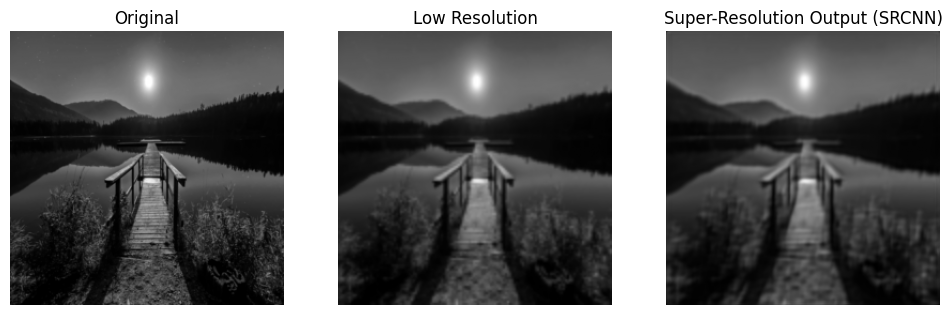

In [8]:
input_img = low_res.reshape(1, 256, 256, 1)
predicted = SRCNN.predict(input_img)[0].reshape(256, 256)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(y, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(low_res, cmap='gray')
plt.title("Low Resolution")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(predicted, cmap='gray')
plt.title("Super-Resolution Output (SRCNN)")
plt.axis('off')

plt.show()
